# Load Forecasting

One of the most important variables for a behind-the-meter energy storage unit is the building's hourly energy consumption (in kWh). In order to appropiately model the optimal dispatch of a behind-the-meter energy storage unit in large commercial buildings, we need a multi-year forecast of the building's load.

We intend on using supervised learning techniques (specifically polynomial regression) to predict this commercial building load. Commercial building load depends on a variety of internal & external factors, including:
* Hour
* Temperature
* Size (space volume)
* Lighting type & consumption
* HVAAC type & consumption
* No. of employees
* Working hours
* No. of electrical vehicles (EV)
* No. of rooms
* and so on...

Unfortunately, most of this data is incredibly hard to come by in training sets. For the purposes of this analysis, we're taking a simplistic approach to commercial load forecasting for a single building by using Outside Air Temperature (OAT) and hour as the independent variables.

Specifically, we'll be using DoE's Reference Building 7 ("Office") hourly energy consumption and outdoor air temperature dataset, where they've published building load data, along with a corresponding timestamp and OAT.

**Sources:**
https://openei.org/datasets/dataset/consumption-outdoor-air-temperature-11-commercial-buildings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import datetime
%matplotlib inline

from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

df = pd.read_csv('./data/building60preoffice.csv')
df.shape

(8735, 3)

# Part 1 - Preprocessing

In [2]:
# Convert to Datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(pd.DatetimeIndex(df['Date']))

df['hour'] = df['Date'].dt.hour

df.head()

,Date,OAT,Building 6 kW,hour
Date,,,,
2009-01-02 00:00:00,2009-01-02 00:00:00,41.6,23.3,0
2009-01-02 01:00:00,2009-01-02 01:00:00,40.9,23.1,1
2009-01-02 02:00:00,2009-01-02 02:00:00,39.5,23.7,2
2009-01-02 03:00:00,2009-01-02 03:00:00,36.3,29.1,3
2009-01-02 04:00:00,2009-01-02 04:00:00,32.8,35.6,4


In [3]:
# Check for empty rows
df.columns[df.isnull().mean() == 0]

# No empty values

Index(['Date', 'OAT', 'Building 6 kW', 'hour'], dtype='object')

# Part 1 - Visualization & Data Exploration

C:\Users\nickb\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


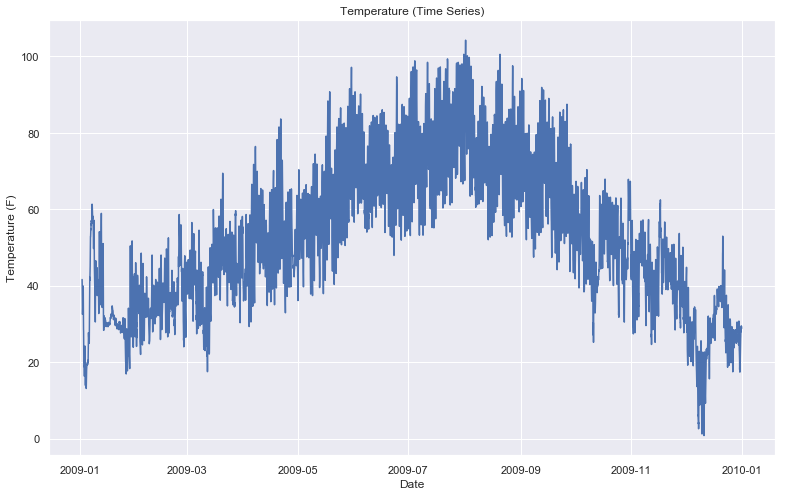

In [4]:
# Visualize building load in time series
sns.set(rc={'figure.figsize':(13, 8)})

ax = sns.lineplot(x="Date", y="OAT", data=df)
ax.set(ylabel='Temperature (F)', title="Temperature (Time Series)")

plt.show()

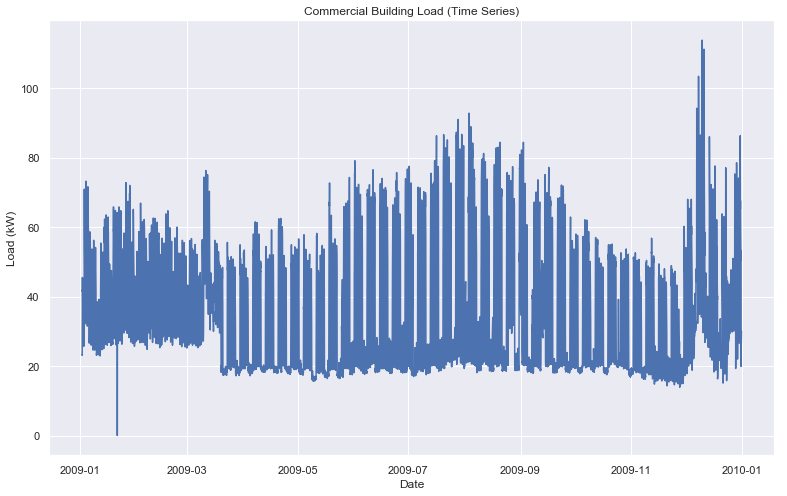

In [5]:
ax = sns.lineplot(x="Date", y="Building 6 kW", data=df)
ax.set(ylabel='Load (kW)', title="Commercial Building Load (Time Series)")

plt.show()

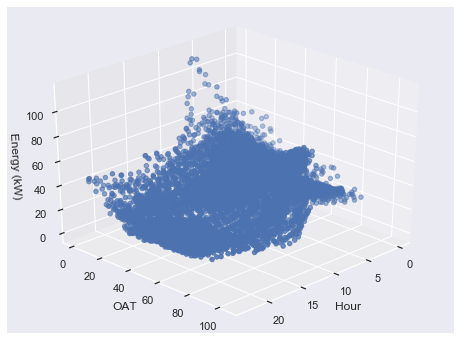

In [6]:
# Visualize all relevat dimensions (hour, OAT, building load) in 3D space
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection="3d")

xs = df['hour']
ys = df['OAT']
zs = df['Building 6 kW']
ax.scatter3D(xs, ys, zs);
ax.view_init(30, 45)

ax.set_xlabel('Hour')
ax.set_ylabel('OAT')
ax.set_zlabel('Energy (kW)')

plt.show()

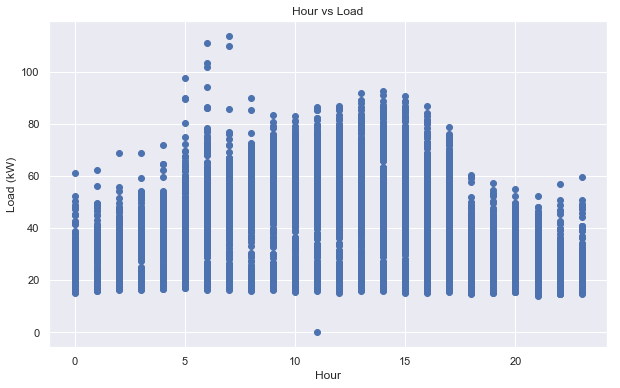

In [25]:
# Plot Hour vs Building Load
sns.set(rc={'figure.figsize':(10, 6)})
plt.scatter(df['hour'], df['Building 6 kW'])
plt.xlabel("Hour")
plt.ylabel("Load (kW)")
plt.title("Hour vs Load")
plt.show()

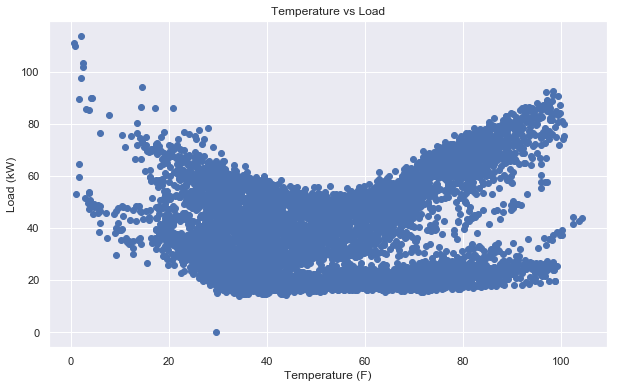

In [27]:
# Plot Temperature vs Building Load
plt.scatter(df['OAT'], df['Building 6 kW'])
plt.xlabel("Temperature (F)")
plt.ylabel("Load (kW)")
plt.title("Temperature vs Load")
plt.show()

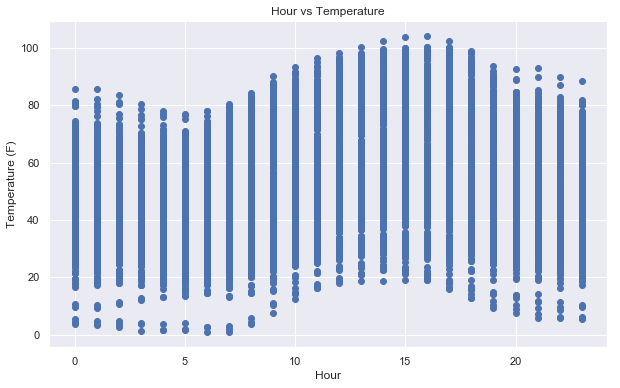

In [28]:
# Plot Hour vs Temperature (F)
plt.scatter(df['hour'], df['OAT'])
plt.xlabel("Hour")
plt.ylabel("Temperature (F)")
plt.title("Hour vs Temperature")
plt.show()

# Part 2 - Modeling

In [10]:
def build_model():
    pipeline = Pipeline([
        ('features', PolynomialFeatures()),
#         ('scaler', StandardScaler()),
        ('reg', Lasso(tol=0.0001))
#         ('clf', SGDRegressor(loss='squared_loss', eta0=0.00001, tol=1e-3, random_state=42))
    ])

    parameters = {
        'features__degree': [2, 3, 4, 5, 6, 7, 8],
        'reg__alpha': [0.1, 1, 5, 10]
#         'clf__max_iter': [2000, 3000],
#         'clf__penalty': ['l2', 'elasticnet'],
    }

    cv = GridSearchCV(pipeline, param_grid=parameters)

    return cv

In [11]:
# Prepare input for model
X = df.as_matrix(columns=['hour', 'OAT'])
y = df['Building 6 kW'].values

model = build_model()
# model.get_params()
model.fit(X,y)

C:\Users\nickb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\

C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nickb\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('reg', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'features__degree': [2, 3, 4, 5, 6, 7, 8], 'reg__alpha': [0.1, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
# Basic test to see if result is within the "makes sense" range
X_test = [[22, 80]]

y_test = model.predict(X_test)

print(y_test)

[18.50578929]


# Part 3 - Predicting

In [13]:
# Import Temperature Data (source below)
# https://www.kaggle.com/selfishgene/historical-hourly-weather-data/downloads/historical-hourly-weather-data.zip/2

df_t = pd.read_csv('./data/temperature.csv')
df_t.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


## Part 3.1 - Preprocessing Test Data

In [14]:
# Remove 1st row (empty)
df_temp = df_t.iloc[1:]

# Isolate Seattle data
df_temp_SE = df_temp[['datetime', 'Seattle']]

df_temp_SE.head()

,datetime,Seattle
1,2012-10-01 13:00:00,281.800000
2,2012-10-01 14:00:00,281.797217
3,2012-10-01 15:00:00,281.789833
4,2012-10-01 16:00:00,281.782449
5,2012-10-01 17:00:00,281.775065


In [15]:
# Check missing values
df_temp_SE['Seattle'].isnull().mean()

4.419694157164324e-05

In [16]:
# Impute with mean (small % of missing values)
df_temp_SE['Seattle'].fillna(df_temp_SE['Seattle'].mean(), inplace=True)

C:\Users\nickb\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [17]:
# Feature Engineer Temperature (K --> F)
df_temp_SE['Seattle (F)'] = (df_temp_SE['Seattle'] / (5/9)) - 459.67

C:\Users\nickb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
# Convert to datetime
df_temp_SE['datetime'] = pd.to_datetime(df_temp_SE['datetime'])
X_pred = df_temp_SE.set_index(pd.DatetimeIndex(df_temp_SE['datetime']))

# Feature Engineer "hour" column
X_pred['hour'] = X_pred['datetime'].dt.hour

X_pred.head()

C:\Users\nickb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,datetime,Seattle,Seattle (F),hour
datetime,,,,
2012-10-01 13:00:00,2012-10-01 13:00:00,281.800000,47.570000,13
2012-10-01 14:00:00,2012-10-01 14:00:00,281.797217,47.564990,14
2012-10-01 15:00:00,2012-10-01 15:00:00,281.789833,47.551699,15
2012-10-01 16:00:00,2012-10-01 16:00:00,281.782449,47.538407,16
2012-10-01 17:00:00,2012-10-01 17:00:00,281.775065,47.525116,17


## Part 3.2 - Visualize Data

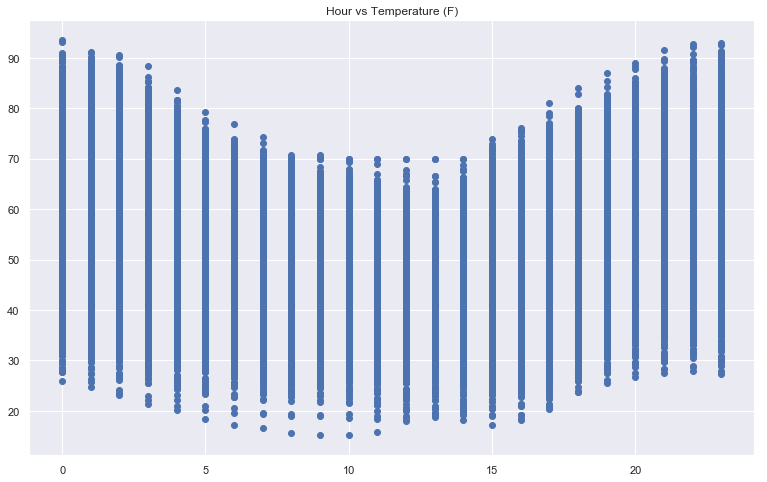

In [19]:
# Visualize Hour vs Temperature (F)
sns.set(rc={'figure.figsize':(10, 6)})

plt.scatter(X_pred['hour'], X_pred['Seattle (F)'])
plt.xlabel("Hour")
plt.ylabel("Temperature (F)")
plt.title("Hour vs Temperature")
plt.show()

In [20]:
# Save Preprocessed Seattle Dataset
X_pred.to_csv('Seattle_TempH.csv')

## Part 3.3 - Predict (Regression)

In [21]:
# Predict using regression model
X_pred_mat = X_pred.as_matrix(columns=['hour', 'Seattle (F)'])

y_pred = model.predict(X_pred_mat)

print(y_pred)
print(y_pred.max())
print(y_pred.min())

[41.95531857 40.38441217 37.97566208 ... 19.14956221 23.5574638
 17.83867696]
65.27807213622762
11.86939238305051


C:\Users\nickb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


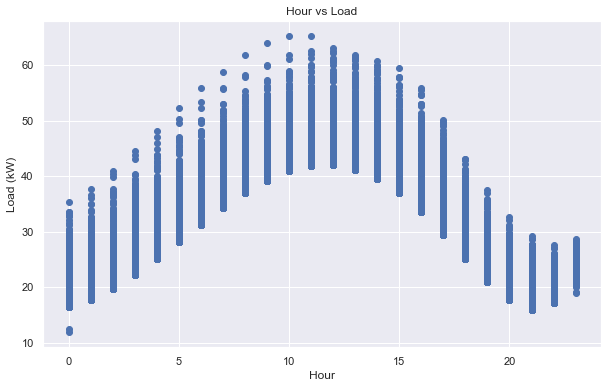

In [32]:
plt.scatter(X_pred['hour'], y_pred)
plt.xlabel("Hour")
plt.ylabel("Load (kW)")
plt.title("Hour vs Load")
plt.show()

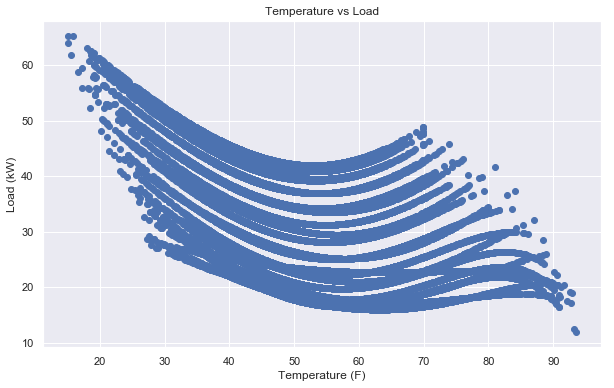

In [34]:
plt.scatter(X_pred['Seattle (F)'], y_pred)
plt.xlabel("Temperature (F)")
plt.ylabel("Load (kW)")
plt.title("Temperature vs Load")
plt.show()

## Part 3.4 - Export Results

In [ ]:
# Reset index for merging
df_temp_SE_new = df_temp_SE.reset_index(drop=True)

df_output = pd.concat([df_temp_SE_new, pd.DataFrame({'Load (kW)': y_pred3})['Load (kW)']], axis=1)
print(df_output.shape)
df_output.head()

In [ ]:
df_output.to_csv('Seattle_Load_H.csv')